## Description:

This file contains:
* **Explore 3 workflow options to see which gives least noise and best clustering**. Workflow options:
    * Opt-1: train on 7 days - predict upto 7 days includibg all past days
    * Opt-2: train on 7 days - predict 7 days without repeating articles
    * Opt-3: train on 7 days - predict 1 day at a time with retrained on past 7 days everytime (rolling window)

In [1]:
""" Helper imports"""
import joblib
import pandas as pd
import numpy as np
from time import time
from nltk.tokenize import sent_tokenize
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity

"""Modeling imports"""
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

""" Plotting imports"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
# add the parent directory path
sys.path.insert(0, '..')

from src.util import (c_tf_idf, 
                      extract_top_n_words_per_topic,
                      extract_topic_sizes,
                      topic_cos_sim_metrics,
                      generate_all_cossim_metrics)

In [3]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 
results_path = '/home/jupyter/bi-topic-modeling/results/' 

SEED = 42

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

### --- Data ---

* Train date range Apr 26 (monday) till May 02 (sunday)
* Eligible pool = articles with pvs > 100 on a given day. In prod this will be replaced by pvs>350 summed over 7 days

In [4]:
def get_data(file_name):
    
    df = pd.read_csv(data_path + file_name)

    print("Before Shape:", df.shape)
    print("Unique tiers:", len(df.tier1.unique()))
    
    # Per verdict from EDA, exclude articles less than 100 words
    df["article_length"] = df.clean_body.str.split().apply(len)
    df = df[df["article_length"]>=100]
    print("After Shape:", df.shape)
    
    df.tier1 = df.tier1.fillna('Other')
    df = df.reset_index(drop=True)
    
    return df

In [5]:
# training data set

print("--- apr 25 ---")

apr25 = get_data('processed/train_apr25_over100pvs_processed.csv')
apr25_art_embed = joblib.load("./data/processed/apr25_article_embed_axis0.joblib")
print("Embeds len:", len(apr25_art_embed))

print()
print("--- apr 26 ---")

apr26 = get_data('processed/pred_apr26_over100pvs_processed.csv')
apr26_art_embed = joblib.load("./data/processed/apr26_article_embed_axis0.joblib")
print("Embeds len:", len(apr26_art_embed))

print()
print("--- apr 27 ---")

apr27 = get_data('processed/pred_apr27_over100pvs_processed.csv')
apr27_art_embed = joblib.load("./data/processed/apr27_article_embed_axis0.joblib")
print("Embeds len:", len(apr27_art_embed))

print()
print("--- apr 28 ---")

apr28 = get_data('processed/apr28_over100pvs_processed.csv')
apr28_art_embed = joblib.load("./data/processed/apr28_article_embed_axis0.joblib")
print("Embeds len:", len(apr28_art_embed))

print()
print("--- apr 29 ---")

apr29 = get_data('processed/apr29_over100pvs_processed.csv')
apr29_art_embed = joblib.load("./data/processed/apr29_article_embed_axis0.joblib")
print("Embeds len:", len(apr29_art_embed))

print()
print("--- apr 30 ---")

apr30 = get_data('processed/apr30_over100pvs_processed.csv')
apr30_art_embed = joblib.load("./data/processed/apr30_article_embed_axis0.joblib")
print("Embeds len:", len(apr30_art_embed))

print("--- may 01 ---")

may01 = get_data('processed/may01_over100pvs_processed.csv')
may01_art_embed = joblib.load("./data/processed/may01_article_embed_axis0.joblib")
print("Embeds len:", len(may01_art_embed))

print()
print("--- may 02 ---")

may02 = get_data('processed/may02_over100pvs_processed.csv')
may02_art_embed = joblib.load("./data/processed/may02_article_embed_axis0.joblib")
print("Embeds len:", len(may02_art_embed))

--- apr 25 ---
Before Shape: (3334, 10)
Unique tiers: 31
After Shape: (3327, 11)
Embeds len: 3327

--- apr 26 ---
Before Shape: (4138, 10)
Unique tiers: 31
After Shape: (4128, 11)
Embeds len: 4128

--- apr 27 ---
Before Shape: (4177, 10)
Unique tiers: 31
After Shape: (4167, 11)
Embeds len: 4167

--- apr 28 ---
Before Shape: (4197, 8)
Unique tiers: 31
After Shape: (4186, 9)
Embeds len: 4186

--- apr 29 ---
Before Shape: (4201, 8)
Unique tiers: 31
After Shape: (4188, 9)
Embeds len: 4188

--- apr 30 ---
Before Shape: (3784, 8)
Unique tiers: 31
After Shape: (3771, 9)
Embeds len: 3771
--- may 01 ---
Before Shape: (3052, 8)
Unique tiers: 31
After Shape: (3044, 9)
Embeds len: 3044

--- may 02 ---
Before Shape: (3267, 8)
Unique tiers: 31
After Shape: (3259, 9)
Embeds len: 3259


In [6]:
# testing data set

print()
print("--- may 03 ---")

may03 = get_data('processed/may03_over100pvs_processed.csv')
may03_art_embed = joblib.load("./data/processed/may03_article_embed_axis0.joblib")
print("Embeds len:", len(may03_art_embed))

print()
print("--- may 04 ---")

may04 = get_data('processed/may04_over100pvs_processed.csv')
may04_art_embed = joblib.load("./data/processed/may04_article_embed_axis0.joblib")
print("Embeds len:", len(may04_art_embed))

print()
print("--- may 05 ---")

may05 = get_data('processed/may05_over100pvs_processed.csv')
may05_art_embed = joblib.load("./data/processed/may05_article_embed_axis0.joblib")
print("Embeds len:", len(may05_art_embed))

print("--- may 06 ---")

may06 = get_data('processed/may06_over100pvs_processed.csv')
may06_art_embed = joblib.load("./data/processed/may06_article_embed_axis0.joblib")
print("Embeds len:", len(may06_art_embed))

print("--- may 07 ---")

may07 = get_data('processed/may07_over100pvs_processed.csv')
may07_art_embed = joblib.load("./data/processed/may07_article_embed_axis0.joblib")
print("Embeds len:", len(may07_art_embed))

print("--- may 08 ---")

may08 = get_data('processed/may08_over100pvs_processed.csv')
may08_art_embed = joblib.load("./data/processed/may08_article_embed_axis0.joblib")
print("Embeds len:", len(may08_art_embed))

print("--- may 09 ---")

may09 = get_data('processed/may09_over100pvs_processed.csv')
may09_art_embed = joblib.load("./data/processed/may09_article_embed_axis0.joblib")
print("Embeds len:", len(may09_art_embed))


--- may 03 ---
Before Shape: (4210, 8)
Unique tiers: 31
After Shape: (4199, 9)
Embeds len: 4199

--- may 04 ---
Before Shape: (4235, 8)
Unique tiers: 31
After Shape: (4223, 9)
Embeds len: 4223

--- may 05 ---
Before Shape: (4174, 8)
Unique tiers: 31
After Shape: (4160, 9)
Embeds len: 4160
--- may 06 ---
Before Shape: (4079, 8)
Unique tiers: 31
After Shape: (4063, 9)
Embeds len: 4063
--- may 07 ---
Before Shape: (3644, 8)
Unique tiers: 31
After Shape: (3630, 9)
Embeds len: 3630
--- may 08 ---
Before Shape: (3038, 8)
Unique tiers: 31
After Shape: (3025, 9)
Embeds len: 3025
--- may 09 ---
Before Shape: (3245, 8)
Unique tiers: 31
After Shape: (3231, 9)
Embeds len: 3231


# Opt-1 and Opt-2

### --- Combine train data - 7 days --- 
* apr 26 (monday) till may 2 (sunday)
* Observations on training clustering performance - same as the one in file shared for review

In [7]:
# concatenate dfs

combined_df = pd.concat([apr26, apr27, apr28, apr29, apr30, may01, may02])
# reset index
combined_df = combined_df.reset_index(drop=True)
# drop unnecessary cols
combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
# fill na
combined_df.tier2 = combined_df.tier2.fillna('Other')
combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
print(combined_df.shape)

# concatenate embeds
combined_embeds = apr26_art_embed + apr27_art_embed + apr28_art_embed + apr29_art_embed + apr30_art_embed + may01_art_embed + may02_art_embed
print(len(combined_embeds))

(26743, 9)
26743


In [8]:
# drop duplicates from df

train_df = combined_df.drop_duplicates(subset="content_natid", keep='first')

print(train_df.shape)
print(train_df.content_natid.duplicated(keep='first').any())

train_embeds =  [combined_embeds[i] for i in list(train_df.index)]
print(len(train_embeds))

(7238, 9)
False
7238


In [9]:
train_df.reset_index(drop=True, inplace=True)

train_df = train_df[['content_natid', 'clean_body', 'tier1']]
train_df.shape

(7238, 3)

* Get train data metrics - 7 days: apr 26 (monday) till may 2 (sunday) per day metrics aggregated at natid (7 day) level

In [10]:
# get training data metrics
apr26_metrics = pd.read_csv(data_path + 'processed/apr26_metrics.csv')
apr27_metrics = pd.read_csv(data_path + 'processed/apr27_metrics.csv')
apr28_metrics = pd.read_csv(data_path + 'processed/apr28_metrics.csv')
apr29_metrics = pd.read_csv(data_path + 'processed/apr29_metrics.csv')
apr30_metrics = pd.read_csv(data_path + 'processed/apr30_metrics.csv')
may01_metrics = pd.read_csv(data_path + 'processed/may01_metrics.csv')
may02_metrics = pd.read_csv(data_path + 'processed/may02_metrics.csv')

combined_metrics = pd.concat([apr26_metrics, apr27_metrics, apr28_metrics, apr29_metrics, apr30_metrics, 
                              may01_metrics, may02_metrics])

apr26_may02_metrics = combined_metrics.groupby('GA_cmsNaturalId').agg({
    'pvs':'sum', 'avg_time_on_page':'mean', 'avg_scroll':'mean'
}).reset_index()

print(apr26_may02_metrics.shape)

(7522, 4)


### --- Modeling ---

In [11]:
data = train_df.clean_body.tolist()
print(len(data))

7238


**Param settings:** Newest -<br>

umap_embeddings =  umap.UMAP(n_neighbors=15,<br>
                             min_dist=0.0,<br>
                             n_components=2,<br>
                             random_state=SEED,<br>
                            ).fit(train_embeds)<br>
<br>
cluster = hdbscan.HDBSCAN(min_cluster_size=5,<br>
                      min_samples = 4, <br>
                      metric= 'euclidean',         
                      cluster_selection_method='eom',<br>
                      prediction_data=True).fit(umap_embeddings.embedding_)


In [12]:
# NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
# hdbscan min_cluster_size=5, min_samples = 4, input = sentence embeddings aggregated (mean) to full article

umap_embeddings =  umap.UMAP(n_neighbors=15,
                             min_dist=0.0,
                             n_components=2,
                             random_state=SEED,
                            ).fit(train_embeds)

In [13]:
# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      min_samples = 4, #new
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings.embedding_)

In [14]:
print("Shape of training embeddings:", umap_embeddings.embedding_.shape)

Shape of training embeddings: (7238, 2)


In [15]:
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.2996882715864831

### HP-Tuning - type1

In [21]:
from sklearn.model_selection import GridSearchCV

def dbcv_score(estimator, X):
    labels = cluster.labels_
    return validity_index(umap_embeddings.embedding_.astype('double'), labels)

cluster_hp = hdbscan.HDBSCAN(metric= 'euclidean', cluster_selection_method='eom', prediction_data=True)

params = {"min_cluster_size": [5, 10, 15], "min_samples": [4,9,14]}

cv = [(slice(None), slice(None))]

# run randomized search
search = GridSearchCV(
    cluster_hp,
    param_grid=params,
    scoring=dbcv_score,
    cv= cv
    )
search.fit(umap_embeddings.embedding_)

GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=HDBSCAN(prediction_data=True),
             param_grid={'min_cluster_size': [5, 10, 15],
                         'min_samples': [4, 9, 14]},
             scoring=<function dbcv_score at 0x7fa80d006680>)

In [22]:
search.best_estimator_

HDBSCAN(min_samples=4, prediction_data=True)

In [23]:
search.best_estimator_.labels_

array([ -1,  46,  56, ...,  44, 187,  -1])

### HP-Tuning - type2

min_dist_params = [0.0, 0.1] # old - 0.1, new - 0.0 <br>
n_neighbors_params = [10, 15, 20] # old - 15, new - 15<br>
n_components_params = [2, 5] # old - 5, new -2 <br>
min_cluster_size_params = [5, 10] # old - 5, new - 5<br>
min_samples_params = [4, 5] # old - none, new - 4

In [ ]:
# list1 = ["a", "b", "c"]
# list2 = [1, 2]

# all_combinations = [list(zip(each_permutation, list2)) for each_permutation in itertools.permutations(list1, len(list2))]

In [17]:
def evaluate_dbcv_score(embeds, pred_labels):
    return validity_index(embeds, pred_labels)

def evaluate_params(train_embeds, n_neighbors_params, n_components_params, min_cluster_size_params, min_samples_params):
    
    best_score, best_cfg = float("inf"), None

    for neigh in n_neighbors_params:
        for comp in n_components_params:
            for clust in min_cluster_size_params:
                for samp in min_samples_params:
                    
                    order = (neigh, comp, clust, samp)

                    try:
                        umap_embeddings_hp = umap.UMAP(n_neighbors= neigh,
                             min_dist = 0.0,
                             n_components = comp,
                             random_state = SEED,
                            ).fit(train_embeds)

                        # cluster
                        cluster_hp = hdbscan.HDBSCAN(min_cluster_size = clust,
                                              min_samples = samp,
                                              metric= 'euclidean',                      
                                              cluster_selection_method='eom',
                                              prediction_data=True).fit(umap_embeddings_hp.embedding_)
                        
                        labels = cluster_hp.labels_
                        score = evaluate_dbcv_score(umap_embeddings_hp.embedding_.astype('double'), labels)
                        
                        print('params%s score=%.3f' % (order, score))

                        if score > best_score:
                            best_score, best_cfg = score, order
                    except:
                        continue
    print('Best params=%s Best Score=%.3f' % (order, score))

In [18]:
n_neighbors_params = [15]
n_components_params = [2]
min_cluster_size_params = [5, 10]
min_samples_params = [4,9]

In [19]:
evaluate_params(train_embeds, n_neighbors_params, n_components_params, min_cluster_size_params, min_samples_params)

#8.17

params(15, 2, 5, 4) score=0.300
params(15, 2, 5, 9) score=0.322
params(15, 2, 10, 4) score=0.224
params(15, 2, 10, 9) score=0.313
Best params=(15, 2, 10, 9) Best Score=0.313


In [16]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df

Distinct topics including -1 for noise 323



,Doc,Topic,Doc_ID
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list ...",-1,0
1,these 11 mattress toppers give you the bed of your dreams. while new pillows or a new set of sheets can do...,46,1
2,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the pa...",56,2
3,apple ios 14.5 released: massive iphone update with cool features & important fixes. april 28 update below...,60,3
4,apple airtag: all you need to know about the game-changing new gadget. april 28 update below. this post wa...,60,4
...,...,...,...
7233,"the oilman, the playmate, and the tangled affairs of the billionaire marshall family. j. howard marshall i...",132,7233
7234,5 surprising foods that help you sleep. cherries: the new melatonin supplement (image via wikipedia) june ...,35,7234
7235,hacker's demo shows how easily credit cards can be read through clothes and wallets. some blank credit car...,44,7235
7236,"the five richest pastors in nigeria. london-based nigerian pastor matthew ashimolowo god is good, especial...",187,7236


In [17]:
# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'topic_words'}) 

In [18]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:6] 
    
    # convert into string
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

end = time.time()
print("keyword time", (end - start)/60) 

keyword time 0.0005437850952148438


In [19]:
top_n_words_df["topic_words"] = clean_keys

In [20]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

# per topic - tier counts
tier_metric = docs_df.join(train_df[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
                               topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               train_cossim_df, on = "topic_num", how="inner"), 
                      iab_metric, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

In [21]:
topic_info.head()

,topic_num,topic_words,Size,cos_min,cos_mean,distinct_tier1s
0,-1,"remote, age, businesses, leaders, workers, water",1946,-0.05,0.71,31
1,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary",34,0.77,0.90,8
2,1,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time",7,0.95,0.97,3
3,2,"pink moon, sky, supermoons, super pink, sun, blood moon",30,0.75,0.88,6
4,3,"def, aew, nxt, wrestlemania, smackdown, live events",14,0.76,0.88,4


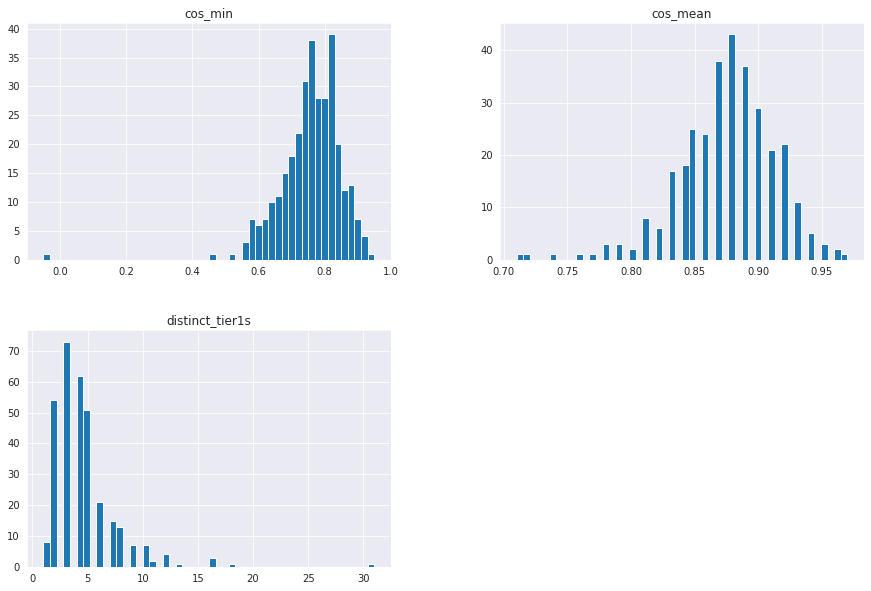

In [22]:
# TEST FOR LESSER NOISE
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,10), bins=50)
plt.show()

In [23]:
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 3))

,cos_min,cos_mean,distinct_tier1s,Size
count,323.000,323.000,323.000,323.000
mean,0.752,0.875,4.601,22.409
std,0.093,0.038,3.022,108.579
min,-0.050,0.710,1.000,5.000
25%,0.710,0.850,3.000,7.000
50%,0.760,0.880,4.000,11.000
75%,0.810,0.900,5.000,19.000
max,0.950,0.970,31.000,1946.000


In [24]:
# joblib.dump(umap_embeddings, "./model/apr26_may2_train_umap_07192021.joblib")
# joblib.dump(cluster, "./model/apr26_may2_train_clusterer_07192021.joblib")

**Topics are about:**


In [25]:
# combine natural id inside docs_df
docs_df = pd.merge(docs_df, train_df, how="left", left_on="Doc", right_on="clean_body")
docs_df.drop("clean_body", axis=1, inplace=True)

In [26]:
# contains natid, article body, assigned topic

full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")
full_train_topics.head(1)

,Doc,Topic,Doc_ID,content_natid,tier1,topic_num,topic_words,Size,cos_min,cos_mean,distinct_tier1s
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",-1,0,blogandpostid/blog/post/4983-5ea87d15960ddf000681c604,Shopping,-1,"remote, age, businesses, leaders, workers, water",1946,-0.05,0.71,31


In [27]:
apr26_may02_metrics.head(3)

,GA_cmsNaturalId,pvs,avg_time_on_page,avg_scroll
0,blogandpostid/blog/post/1007-35894,678,185.901976,0.524951
1,blogandpostid/blog/post/1011-12712,103,90.669903,0.361650
2,blogandpostid/blog/post/1011-2227,134,99.514925,0.419776


In [28]:
final = pd.merge(full_train_topics, apr26_may02_metrics, left_on="content_natid", right_on="GA_cmsNaturalId", how="inner")
final.shape

(7238, 15)

In [29]:
train_calcs = final.groupby('Topic').agg({'pvs':'sum', 'avg_time_on_page':'mean', 'avg_scroll':'mean',
                                        'content_natid':'nunique'}).reset_index()

train_calcs.sort_values("avg_time_on_page", ascending=False).head()

,Topic,pvs,avg_time_on_page,avg_scroll,content_natid
19,18,34020,179.954223,0.368528,38
196,195,6241,176.444653,0.386669,6
312,311,4328,171.410591,0.449847,7
208,207,11210,169.101821,0.397428,10
23,22,9228,167.514232,0.359044,14


In [30]:
# TEST FOR LESSER NOISE
# final.to_csv(results_path+"review_apr26_may02_trained_topics.csv", index=False)
# not saving again - refer to file shared for review for obs

* Noise

In [31]:
# data shared for review -- trained topics = 323. Noise = 27% (1946/7238)
# now -- trained topics = 328. Noise = 31% (2227/7238)

round(full_train_topics[full_train_topics.Topic==-1].shape[0]/full_train_topics.shape[0]*100)

27

In [32]:
topic_info[['Size', 'cos_min', 'cos_mean']].describe()

,Size,cos_min,cos_mean
count,323.000000,323.000000,323.000000
mean,22.408669,0.751858,0.874551
std,108.579164,0.093169,0.038473
min,5.000000,-0.050000,0.710000
25%,7.000000,0.710000,0.850000
50%,11.000000,0.760000,0.880000
75%,19.000000,0.810000,0.900000
max,1946.000000,0.950000,0.970000


### Opt-1 Prediction
* same model predict on 7 days with repeating articles

**Training data**

* Date range 7 days -- Apr 26 (monday) till May 02 (sunday)

* Eligible pool = articles with pvs threshold = 7,238 articles
    * **Distinct topics including -1 for noise :: 328**

**Prediction data**

* Date range -- may 3 (monday) till May 09 (friday)
* May 3 to May 9 repeating articles present
* Eligible pool = articles with pvs > 100

In [33]:
# umap_embeddings = joblib.load("./model/apr26_may2_train_umap_07192021.joblib")
# cluster = joblib.load("./model/apr26_may2_train_clusterer_07192021.joblib")

print(umap_embeddings)
print()
print(cluster)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, random_state=42)

HDBSCAN(min_samples=4, prediction_data=True)


In [34]:
top_n_words_df.head()

,topic_num,topic_words
0,-1,"remote, age, businesses, leaders, workers, water"
1,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary"
2,1,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time"
3,2,"pink moon, sky, supermoons, super pink, sun, blood moon"
4,3,"def, aew, nxt, wrestlemania, smackdown, live events"


In [35]:
def predict(umap_embeddings, cluster, embed_list, pred_df):
    
    # dimensionality reduction
    pred_umap_embeddings = umap_embeddings.transform(embed_list)

    print("Training input shape:", umap_embeddings.embedding_.shape)
    print("Prediction input shape:", pred_umap_embeddings.shape) #takes a min
    print()
    
    # predict
    pred_test_labels, pred_strengths = hdbscan.approximate_predict(cluster, pred_umap_embeddings)
    
    # put topics in dataframe
    pred_docs_df = pred_df[['clean_body']]
    pred_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
    pred_docs_df["Topic"] = pred_test_labels

    print("Distinct topics including -1 for noise", len(pred_docs_df.Topic.unique()))
    
    pred_topic_sizes = extract_topic_sizes(pred_docs_df)

    # GENERATE TOPIC METRICS

    # per topic - cos_min and cos_mean
    pred_cossim_df = generate_all_cossim_metrics(pred_docs_df, pred_umap_embeddings)

    # per topic - tier counts
    tier_metric = pred_docs_df.join(pred_df[["tier1"]])

    iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                                   'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                        'distinct_tier1s',
                                                                                                        'Topic':
                                                                                                        'topic_num'})

    # combine topic, top words, cos and tier metrics
    topic_info_pred = pd.merge(pd.merge(pred_topic_sizes, 
                                            pred_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                                   iab_metric, on = "topic_num", how="inner")

    topic_info_pred.drop('Topic', axis=1, inplace=True)

    # combine topic_info with topic names

    topic_info_pred = pd.merge(topic_info_pred, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")
    
    # combine natural id inside docs_df

    pred_docs_df = pd.merge(pred_docs_df, pred_df, how="left", left_on="Doc", right_on="clean_body")
    pred_docs_df.drop("clean_body", axis=1, inplace=True)
    
    pred_full = pd.merge(pred_docs_df, 
         topic_info_pred, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)
    
    return pred_full, pred_docs_df, topic_info_pred, pred_strengths

* **Predict new points/articles - May 3**

In [36]:
start = time.time()

pred_may03_full, may03_docs_df, topic_info_may03, may03_strengths = predict(umap_embeddings, cluster, 
                                                                            may03_art_embed, may03) 

# NOISE
print("Rows: ", pred_may03_full[pred_may03_full.Topic==-1].shape)
print("Perc: ", round(pred_may03_full[pred_may03_full.Topic==-1].shape[0]/pred_may03_full.shape[0] * 100))

end = time.time()

print()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (4199, 2)

Distinct topics including -1 for noise 310
Rows:  (1784, 15)
Perc:  42

time (mins):  0.34


,cos_min,cos_mean,distinct_tier1s,Size
count,286.00,286.00,310.00,310.00
mean,1.00,1.00,3.04,13.55
std,0.04,0.00,2.37,101.23
min,0.37,0.95,1.00,1.00
25%,1.00,1.00,2.00,3.00
50%,1.00,1.00,3.00,5.00
75%,1.00,1.00,4.00,9.00
max,1.00,1.00,31.00,1784.00


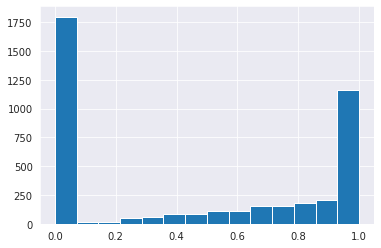

In [37]:
plt.hist(may03_strengths, bins='auto')
plt.show()

* **Predict new points/articles - May 04**

In [38]:
start = time.time()

pred_may04_full, may04_docs_df, topic_info_may04, may04_strengths = predict(umap_embeddings, cluster, 
                                                                            may04_art_embed, may04) 

# NOISE
print("Rows: ", pred_may04_full[pred_may04_full.Topic==-1].shape)
print("Perc: ", round(pred_may04_full[pred_may04_full.Topic==-1].shape[0]/pred_may04_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

Training input shape: (7238, 2)
Prediction input shape: (4223, 2)

Distinct topics including -1 for noise 298
Rows:  (1964, 15)
Perc:  47
time (mins):  0.14


* **Predict new points/articles - May 05**

In [39]:
start = time.time()

pred_may05_full, may05_docs_df, topic_info_may05, may05_strengths = predict(umap_embeddings, cluster, 
                                                                            may05_art_embed, may05) 

# NOISE
print("Rows: ", pred_may05_full[pred_may05_full.Topic==-1].shape)
print("Perc: ", round(pred_may05_full[pred_may05_full.Topic==-1].shape[0]/pred_may05_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may05[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (4160, 2)

Distinct topics including -1 for noise 311
Rows:  (1797, 15)
Perc:  43
time (mins):  0.12


,cos_min,cos_mean,distinct_tier1s,Size
count,269.00,269.00,311.00,311.00
mean,1.00,1.00,3.04,13.38
std,0.04,0.00,2.48,101.81
min,0.35,0.95,1.00,1.00
25%,1.00,1.00,2.00,3.00
50%,1.00,1.00,3.00,5.00
75%,1.00,1.00,4.00,9.00
max,1.00,1.00,31.00,1797.00


* **Predict new points/articles - May 06**

In [40]:
start = time.time()

pred_may06_full, may06_docs_df, topic_info_may06, may06_strengths = predict(umap_embeddings, cluster, 
                                                                            may06_art_embed, may06) 

# NOISE
print("Rows: ", pred_may06_full[pred_may06_full.Topic==-1].shape)
print("Perc: ", round(pred_may06_full[pred_may06_full.Topic==-1].shape[0]/pred_may06_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may06[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (4063, 2)

Distinct topics including -1 for noise 292
Rows:  (1950, 15)
Perc:  48
time (mins):  0.13


,cos_min,cos_mean,distinct_tier1s,Size
count,247.00,247.00,292.00,292.00
mean,1.00,1.00,3.01,13.91
std,0.04,0.00,2.51,113.95
min,0.34,0.94,1.00,1.00
25%,1.00,1.00,1.00,2.00
50%,1.00,1.00,3.00,5.00
75%,1.00,1.00,4.00,9.25
max,1.00,1.00,31.00,1950.00


* **Predict new points/articles - May 07**

In [41]:
start = time.time()

pred_may07_full, may07_docs_df, topic_info_may07, may07_strengths = predict(umap_embeddings, cluster, 
                                                                            may07_art_embed, may07) 

# NOISE
print("Rows: ", pred_may07_full[pred_may07_full.Topic==-1].shape)
print("Perc: ", round(pred_may07_full[pred_may07_full.Topic==-1].shape[0]/pred_may07_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may07[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (3630, 2)

Distinct topics including -1 for noise 287
Rows:  (1676, 15)
Perc:  46
time (mins):  0.12


,cos_min,cos_mean,distinct_tier1s,Size
count,244.00,244.00,287.00,287.00
mean,1.00,1.00,2.89,12.65
std,0.04,0.00,2.41,98.79
min,0.32,0.94,1.00,1.00
25%,1.00,1.00,1.00,2.00
50%,1.00,1.00,2.00,5.00
75%,1.00,1.00,4.00,8.00
max,1.00,1.00,30.00,1676.00


* **Predict new points/articles - May 08**

In [42]:
start = time.time()

pred_may08_full, may08_docs_df, topic_info_may08, may08_strengths = predict(umap_embeddings, cluster, 
                                                                            may08_art_embed, may08) 

# NOISE
print("Rows: ", pred_may08_full[pred_may08_full.Topic==-1].shape)
print("Perc: ", round(pred_may08_full[pred_may08_full.Topic==-1].shape[0]/pred_may08_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may08[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (3025, 2)

Distinct topics including -1 for noise 277
Rows:  (1379, 15)
Perc:  46
time (mins):  0.12


,cos_min,cos_mean,distinct_tier1s,Size
count,218.00,218.00,277.00,277.00
mean,1.00,1.00,2.66,10.92
std,0.04,0.00,2.30,82.77
min,0.36,0.94,1.00,1.00
25%,1.00,1.00,1.00,2.00
50%,1.00,1.00,2.00,4.00
75%,1.00,1.00,3.00,7.00
max,1.00,1.00,29.00,1379.00


* **Predict new points/articles - May 09**

In [43]:
start = time.time()

pred_may09_full, may09_docs_df, topic_info_may09, may09_strengths = predict(umap_embeddings, cluster, 
                                                                            may09_art_embed, may09) 

# NOISE
print("Rows: ", pred_may09_full[pred_may09_full.Topic==-1].shape)
print("Perc: ", round(pred_may09_full[pred_may09_full.Topic==-1].shape[0]/pred_may09_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may09[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (3231, 2)

Distinct topics including -1 for noise 281
Rows:  (1509, 15)
Perc:  47
time (mins):  0.11


,cos_min,cos_mean,distinct_tier1s,Size
count,229.00,229.00,281.00,281.00
mean,1.00,1.00,2.69,11.50
std,0.04,0.00,2.37,89.91
min,0.35,0.94,1.00,1.00
25%,1.00,1.00,1.00,2.00
50%,1.00,1.00,2.00,4.00
75%,1.00,1.00,3.00,8.00
max,1.00,1.00,31.00,1509.00


In [44]:
# **Note:** 
# * There will be articles read between Apr 26 - May 02 (training set), which will also be read on May 03. 
# * These common articles present in prediction set, will get the same topic cluster as before

# **For now:**
# * Predict on whole of may03

# --- EDA ---

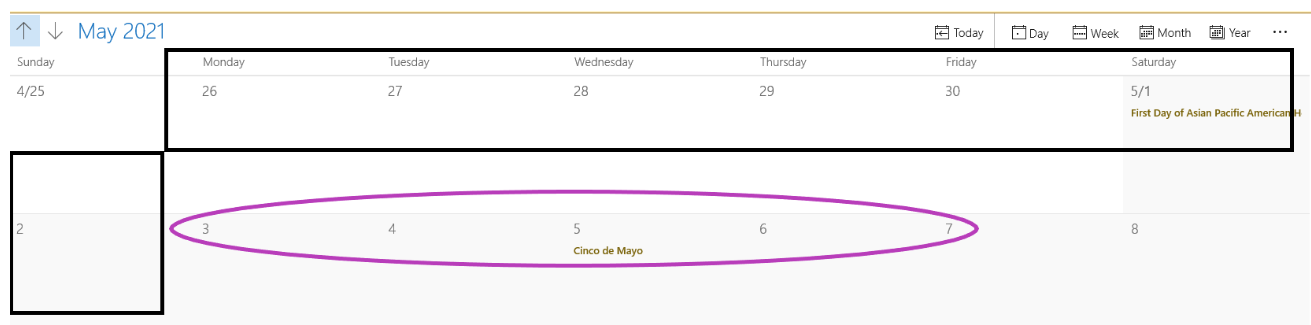

In [45]:
print("Eligible articles:")
print("May 3 -", pred_may03_full.shape)
print("May 4 -", pred_may04_full.shape)
print("May 5 -", pred_may05_full.shape)
print("May 6 -", pred_may06_full.shape)
print("May 7 -", pred_may07_full.shape)
print("May 8 -", pred_may08_full.shape)
print("May 9 -", pred_may09_full.shape)

Eligible articles:
May 3 - (4199, 15)
May 4 - (4223, 15)
May 5 - (4160, 15)
May 6 - (4063, 15)
May 7 - (3630, 15)
May 8 - (3025, 15)
May 9 - (3231, 15)


In [46]:
print("Number of Topics assigned:")
print("May 3 -",len(pred_may03_full.Topic.unique()))
print("May 4 -",len(pred_may04_full.Topic.unique()))
print("May 5 -",len(pred_may05_full.Topic.unique()))
print("May 6 -",len(pred_may06_full.Topic.unique()))
print("May 7 -",len(pred_may07_full.Topic.unique()))
print("May 8 -",len(pred_may08_full.Topic.unique()))
print("May 9 -",len(pred_may09_full.Topic.unique()))

Number of Topics assigned:
May 3 - 310
May 4 - 298
May 5 - 311
May 6 - 292
May 7 - 287
May 8 - 277
May 9 - 281


In [47]:
print("Avg topic size:")
print("May 3 -",round(topic_info_may03.Size.mean()))
print("May 4 -",round(topic_info_may04.Size.mean()))
print("May 5 -",round(topic_info_may05.Size.mean()))
print("May 6 -",round(topic_info_may06.Size.mean()))
print("May 7 -",round(topic_info_may07.Size.mean()))
print("May 8 -",round(topic_info_may08.Size.mean()))
print("May 9 -",round(topic_info_may09.Size.mean()))

Avg topic size:
May 3 - 14
May 4 - 14
May 5 - 13
May 6 - 14
May 7 - 13
May 8 - 11
May 9 - 11


**Observation:**
* On avg. 9 articles form a topic

In [48]:
common_5 = pd.merge(pd.merge(pd.merge(pd.merge(topic_info_may03[["topic_num"]], 
                                                topic_info_may04[["topic_num"]], on="topic_num", how="inner"), 
                                       topic_info_may05[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may06[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may07[["topic_num"]], on="topic_num", how="inner")

print("Common topics across 5 days - ", len(common_5))

Common topics across 5 days -  258


In [49]:
common_7 =  pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(topic_info_may03[["topic_num"]], 
                                                topic_info_may04[["topic_num"]], on="topic_num", how="inner"), 
                                       topic_info_may05[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may06[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may07[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may08[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may09[["topic_num"]], on="topic_num", how="inner")

print("Common topics across 5 days - ", len(common_7))

Common topics across 5 days -  236


In [50]:
common_articles = pd.merge(pd.merge(pd.merge(pd.merge(pred_may03_full[["content_natid", "Topic", "topic_words"]], 
                                                pred_may04_full[["content_natid", "Topic", "topic_words"]], on="content_natid", how="inner"), 
                                       pred_may05_full[["content_natid", "Topic", "topic_words"]], on="content_natid", how="inner"), 
                     pred_may06_full[["content_natid", "Topic", "topic_words"]], on="content_natid", how="inner"), 
                     pred_may07_full[["content_natid", "Topic", "topic_words"]], on="content_natid", how="inner")

print("Common topics across 5 days - ", len(common_articles))

Common topics across 5 days -  2323


### Noise Comparison 

**Observation:**
* On avg. 50% - 54% articles get clustered into a topic each day and rest is deemed as noise by HDBSCAN 

In [51]:
print("# of articles NOISE - ")
print("May 3 -",round(pred_may03_full[pred_may03_full.Topic==-1].shape[0]))
print("May 4 -",round(pred_may04_full[pred_may04_full.Topic==-1].shape[0]))
print("May 5 -",round(pred_may05_full[pred_may05_full.Topic==-1].shape[0]))
print("May 6 -",round(pred_may06_full[pred_may06_full.Topic==-1].shape[0]))
print("May 7 -",round(pred_may07_full[pred_may07_full.Topic==-1].shape[0]))
print("May 8 -",round(pred_may08_full[pred_may08_full.Topic==-1].shape[0]))
print("May 9 -",round(pred_may09_full[pred_may09_full.Topic==-1].shape[0]))

# of articles NOISE - 
May 3 - 1784
May 4 - 1964
May 5 - 1797
May 6 - 1950
May 7 - 1676
May 8 - 1379
May 9 - 1509


In [52]:
print("Perc of articles NOISE - ")
print("May 3 -",round(pred_may03_full[pred_may03_full.Topic==-1].shape[0]/pred_may03_full.shape[0]*100))
print("May 4 -",round(pred_may04_full[pred_may04_full.Topic==-1].shape[0]/pred_may04_full.shape[0]*100))
print("May 5 -",round(pred_may05_full[pred_may05_full.Topic==-1].shape[0]/pred_may05_full.shape[0]*100))
print("May 6 -",round(pred_may06_full[pred_may06_full.Topic==-1].shape[0]/pred_may06_full.shape[0]*100))
print("May 7 -",round(pred_may07_full[pred_may07_full.Topic==-1].shape[0]/pred_may07_full.shape[0]*100))
print("May 8 -",round(pred_may08_full[pred_may08_full.Topic==-1].shape[0]/pred_may08_full.shape[0]*100))
print("May 9 -",round(pred_may09_full[pred_may09_full.Topic==-1].shape[0]/pred_may09_full.shape[0]*100))

Perc of articles NOISE - 
May 3 - 42
May 4 - 47
May 5 - 43
May 6 - 48
May 7 - 46
May 8 - 46
May 9 - 47


## Cluster noise points

In [142]:
may3_nonnoise_df = pred_may03_full[pred_may03_full.Topic!=-1].copy()
may3_noise_df = pred_may03_full[pred_may03_full.Topic==-1].copy()

print(pred_may03_full.shape)
print(may3_nonnoise_df.shape)
print(may3_noise_df.shape) # 42% noise

may3_nonnoise_embeds = [may03_art_embed[i] for i in list(may3_nonnoise_df.index)] 
print(len(may3_nonnoise_embeds))

may3_noise_embeds = [may03_art_embed[i] for i in list(may3_noise_df.index)] 
print(len(may3_noise_embeds))

(4199, 15)
(2415, 15)
(1784, 15)
2415
1784


* **Assign article to closest topic embedding**

In [161]:
print("Unique predicted topics in May3 - ", len(sorted(may3_nonnoise_df.Topic.unique())))
print("Non-noise articles in May3", may3_nonnoise_df.shape)

topic_info_may03.describe()

Unique predicted topics in May3 -  309
Non-noise articles in May3 (2415, 15)


,Size,topic_num,cos_min,cos_mean,distinct_tier1s
count,310.000000,310.000000,286.000000,286.000000,310.000000
mean,13.545161,157.800000,0.997762,0.999825,3.041935
std,101.228807,92.376982,0.037255,0.002957,2.373297
min,1.000000,-1.000000,0.370000,0.950000,1.000000
25%,3.000000,78.250000,1.000000,1.000000,2.000000
50%,5.000000,156.500000,1.000000,1.000000,3.000000
75%,9.000000,236.750000,1.000000,1.000000,4.000000
max,1784.000000,320.000000,1.000000,1.000000,31.000000


In [162]:
may3_nonnoise_df.reset_index(drop=True, inplace=True)
may3_noise_df.reset_index(drop=True, inplace=True)

In [163]:
test = []

for topic_num in sorted(may3_nonnoise_df.Topic.unique()):
    
    topic_group = may3_nonnoise_df[may3_nonnoise_df.Topic== topic_num]
    # grab all articles of given topic
    group_embeddings = [may3_nonnoise_embeds[i] for i in list(topic_group.index)]
    
    # calculate average embedding for each topic
    test.append(np.mean(group_embeddings, axis=0))

print(len(test))

309


In [164]:
print(sorted(may3_nonnoise_df.Topic.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 2

In [122]:
check = may3_nonnoise_df[['Topic', 'topic_words']].drop_duplicates(keep='first').sort_values("Topic")
check[check.topic_words.str.contains("culture")]

,Topic,topic_words
24,163,"tyler, gaslighter narcissist, gaslighters narcissists, puppet, cancel culture, igor theme"
413,299,"culture, leadership, hr, diversity, team members, skills"
284,300,"cultures, boss, promotion, innovation, baldoni, candidates"
1620,314,"sign toxic, toxic culture, resume, kh, manager, bullying"


In [124]:
# test case to cluster

may3_noise_df.iloc[1780].title

'How Do You Change An Organizational Culture?'

In [137]:
np.argmax(list(cos_mat[0][1:]))

256

In [140]:
cos_mat[0][1:][256]

0.9249606

In [141]:
sorted(cos_mat[0][1:])[-1]

0.9249606

In [125]:
import scipy
from sklearn.metrics.pairwise import cosine_similarity

test.insert(0, may3_noise_embeds[1780])
print("Insert: ", len(test))

# convert list to sparse matrix
sparse_matrix= scipy.sparse.csr_matrix(test)

# full matrix of cosine similarity of every embedding/article with every other
cos_mat = cosine_similarity(sparse_matrix)

# find closest topic
print(np.argmax(cos_mat[0][1:]))

test.pop(0)
print("Pop: ", len(test))

Insert:  310
256
Pop:  309


In [126]:
topic_info_may03[topic_info_may03.topic_num==256]

,Size,topic_num,cos_min,cos_mean,distinct_tier1s,topic_words
220,3,256,1.0,1.0,3,"dela cruz, blumenfeld, hurwitz, russell, spoken word, vincenzo"


In [181]:
# automated loop

import scipy
from sklearn.metrics.pairwise import cosine_similarity

closest_topic = []
cos_topic_art = []
print("Orig: ", len(test))

for i in range(len(may3_noise_embeds)):
    
    test.insert(0, may3_noise_embeds[i])
    # print("Insert: ", len(test))
    
    # convert list to sparse matrix
    sparse_matrix= scipy.sparse.csr_matrix(test)

    # full matrix of cosine similarity of every embedding/article with every other
    cos_mat = cosine_similarity(sparse_matrix)
    
    cos_topic_art.append(sorted(cos_mat[0][1:])[-1])
    
    if sorted(cos_mat[0][1:])[-1] >=0.93:
        # find closest topic
        closest_topic.append(sorted(may3_nonnoise_df.Topic.unique())[np.argmax(cos_mat[0][1:])])
    else:
        closest_topic.append(-1)
    
    test.pop(0)
    # print("Pop: ", len(test)) # 4mins

Orig:  309


In [180]:
# with 0.95 threshold
len([x for x in closest_topic if x==-1])

1390

In [183]:
# with 0.93 threshold
len([x for x in closest_topic if x==-1])

867

In [184]:
print(len(closest_topic))
may3_noise_df["cossin_closest"] = closest_topic

1784


In [185]:
cossin_insp = pd.merge(may3_noise_df, topic_info_may03[['topic_num', 'topic_words']], 
         how="left", left_on="cossin_closest", right_on="topic_num")
cossin_insp.isna().sum()

Doc                   0
Topic                 0
pvs                   0
total_timeonpage      0
content_natid         0
pub_date              0
title                 0
tier1                 0
tier2               616
article_length        0
Size                  0
cos_min               0
cos_mean              0
distinct_tier1s       0
topic_words_x         0
cossin_closest        0
topic_num             0
topic_words_y         0
dtype: int64

In [186]:
cossin_insp.to_csv("may3_cossin_insp_thresh.csv", index=False)

* **HDBSCAN again on noise-only**
    * Remember: 
        * I am using option 1. There were some articles which had topic in training But on May 3 prediction, they got noise. Lets call this disgruntled sample. 
        * Now I will cluster only on noise points which will make the disgruntled sample be considered separate to the trained cluster topics. So, algorithm will try to find separate topics for the disgruntled sample articles
            * TODO: if these disgruntled still stay noise?
        * Its still fine - because I plan on merging newly found topics with similar existing ones

In [90]:
col_list = ['content_natid', 'Doc', 'Topic', 'topic_words']

may3_train_common = pd.merge(full_train_topics[col_list],
                             may3_noise_df[col_list], 
                             on = "content_natid", how="inner")
may3_train_common.shape

(1484, 7)

In [121]:
may3_noise_df[may3_noise_df.content_natid.isin(full_train_topics.content_natid)].shape

(1484, 15)

In [91]:
# 47% disgruntled articles i.e. almost half
print(may3_train_common[(may3_train_common.Topic_x !=-1) & (may3_train_common.Topic_y==-1)].shape)

# 53% are noise given by both
print(may3_train_common[(may3_train_common.Topic_x ==-1) & (may3_train_common.Topic_y==-1)].shape)

print(may3_train_common[(may3_train_common.Topic_x ==-1) & (may3_train_common.Topic_y!=-1)].shape)

(693, 7)
(791, 7)
(0, 7)


In [92]:
# NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
# hdbscan min_cluster_size=5, min_samples = 4, input = sentence embeddings aggregated (mean) to full article

umap_embeddings =  umap.UMAP(n_neighbors=15,
                             min_dist=0.0,
                             n_components=2,
                             random_state=SEED,
                            ).fit(may3_noise_embeds)

# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      min_samples = 4, #new
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings.embedding_)

print("Shape of training embeddings:", umap_embeddings.embedding_.shape)
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Shape of training embeddings: (1784, 2)
Settings - mean axis=0


0.3107760703202861

In [93]:
# put topics in dataframe
docs_df = pd.DataFrame(may3_noise_df.Doc.tolist(), columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df

Distinct topics including -1 for noise 83



,Doc,Topic,Doc_ID
0,"announced at wwdc, macos monterey makes the new imac even harder to resist. the new 24-inch imac is a remarkable machine; powered by apples new m1 processor, it feels modern and up-to-date in a way that imacs havent for a number of years. its now...",11,0
1,the new ipad pro 2021 gets even better with tons of new features announced at wwdc. it was just over a year ago that apple unveiled its last ipad pro. the 2020 model wasnt a significant improvement over 2018sit mainly added support for the laptop...,11,1
2,"13 pool floats for the whole family (yes, your dog too). theres only so much lemonade you can drink on your favorite lounge chair by the pool before the itch to jump in the water kicks in. but if youve been relaxing, reading or sipping on your fa...",9,2
3,"these 12 pillows for neck pain will have you waking up feeling brand new. if youre someone who suffers from chronic neck pain, it can be difficult to get a good nights sleep. and while a really great mattress can do a lot to alleviate some amount...",10,3
4,"15 aapi fashion brands to support this month and beyond. even though maythe month that asian american and pacific islander heritage month is recognizedis almost over, when you shop at the fashion retailers and brands on this list, youll also be s...",57,4
...,...,...,...
1779,why are manholes round? the 10 toughest interview questions. a job interview at one of google 's 75 campuses around the globe might seem to have more in common with pledging a secret fraternity than job-hunting. an often months-long interview pro...,78,1779
1780,"how do you change an organizational culture?. changing an organizations culture is one of the most difficult leadership challenges. thats because an organizations culture comprises an interlocking set of goals, roles, processes, values, communica...",-1,1780
1781,"understanding how assets get divided in divorce. dividing the familys property during divorce can be quite difficult, especially if there are significant assets such as houses, rental property, retirement and pension plans, stock options, restric...",33,1781
1782,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1,1782


In [94]:
# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'topic_words'}) 

In [95]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:6] 
    
    # convert into string
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

top_n_words_df["topic_words"] = clean_keys

end = time.time()
print("keyword time", (end - start)/60) 

keyword time 0.00015198389689127605


In [96]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

# per topic - tier counts
tier_metric = docs_df.join(train_df[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
                               topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               train_cossim_df, on = "topic_num", how="inner"), 
                      iab_metric, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

In [97]:
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 3))

,cos_min,cos_mean,distinct_tier1s,Size
count,83.000,83.000,83.000,83.000
mean,0.444,0.705,8.193,21.494
std,0.108,0.028,4.098,57.157
min,0.080,0.640,3.000,5.000
25%,0.380,0.690,5.000,7.000
50%,0.450,0.710,8.000,12.000
75%,0.520,0.720,10.000,21.500
max,0.680,0.760,30.000,527.000


In [104]:
top_n_words_df

,topic_num,topic_words
0,-1,"billion, market, business, companies, data, money"
1,0,"spot, city streets, baidu, fsd, herm, auction"
2,1,"bay, cannabis, island, hotel, menu, south walton"
3,2,"path exile, pokemon, map, dexterity, ascendancy, classes"
4,3,"galley, design, space, cbd, hair, faux"
...,...,...
78,77,"tell time, mcguigan, interview, rahm, job, maternity leave"
79,78,"job, working home, employees, youre, team, telecommuting"
80,79,"food, data, national digital, consumers, businesses, digital id"
81,80,"ai, data, machines, machine learning, tanium, technology"


In [135]:
noise_clustered = pd.merge(docs_df, top_n_words_df, how="left", left_on="Topic", right_on = "topic_num")
noise_clustered.drop("topic_num", axis=1, inplace=True)
noise_clustered["content_natid"] = list(may3_noise_df.content_natid)

In [137]:
# contains natid, article body, assigned topic

full_noise_topics = pd.merge(noise_clustered, topic_info, how="left", left_on="Topic", right_on="topic_num")
print(full_noise_topics.shape)
full_noise_topics.head(1)

(1784, 11)


,Doc,Topic,Doc_ID,topic_words_x,content_natid,topic_num,topic_words_y,Size,cos_min,cos_mean,distinct_tier1s
0,"announced at wwdc, macos monterey makes the new imac even harder to resist. the new 24-inch imac is a remarkable machine; powered by apples new m1 processor, it feels modern and up-to-date in a way that imacs havent for a number of years. its now...",11,0,"m1, apple, macbook pro, surface, 4k, xbox series",blogandpostid/blog/post/4983-607a09a3ceedec00067a07e4,11,"m1, apple, macbook pro, surface, 4k, xbox series",26,0.42,0.7,11


In [140]:
full_noise_topics[full_noise_topics.content_natid.isin(may3_noise_df.content_natid)].shape

(1784, 11)

In [141]:
# full_noise_topics.to_csv("may3_noise_hdbscan_insp.csv", index=False)

In [145]:
print(noise_clustered[noise_clustered.content_natid.isin(may3_train_common.content_natid)].shape)
noise_clustered[noise_clustered.content_natid.isin(may3_train_common.content_natid)].Topic.value_counts()

(1484, 5)


-1     433
 76     61
 31     38
 64     31
 63     27
      ... 
 51      3
 25      3
 59      3
 60      2
 62      1
Name: Topic, Length: 83, dtype: int64

In [147]:
may3_train_common[may3_train_common.content_natid =='blogandpostid/blog/post/28-5380']

,content_natid,Doc_x,Topic_x,topic_words_x,Doc_y,Topic_y,topic_words_y
1064,blogandpostid/blog/post/28-5380,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",118,"alexander, joon, woke, psychopaths, scarecrows, rosenthal","alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1,"remote, age, businesses, leaders, workers, water"


* **kNN**
    * Observation - 7/12 topic assignment to articles were half/completely bad
    * kNN is deterministic, not probabilistic. So, cant assign threshold for point belong to a clustering in an effort to improve topic assignment
    * Decision - not going with this

In [87]:
print(may3_nonnoise_df.shape)
print(len(may3_nonnoise_embeds))
print(may3_noise_df.shape) # 42% noise
print(len(may3_noise_embeds))

non_noise_stacked = pd.DataFrame(np.stack(may3_nonnoise_embeds, axis=0 ))
print(non_noise_stacked.shape)

noise_stacked = pd.DataFrame(np.stack(may3_noise_embeds, axis=0 ))
print(noise_stacked.shape)

(2415, 15)
2415
(1784, 15)
1784
(2415, 768)
(1784, 768)


In [79]:
from sklearn.neighbors import KNeighborsClassifier

x_training_data, y_training_data = non_noise_stacked.iloc[:-100,], may3_nonnoise_df.iloc[:-100, 1]
x_test_data, y_test_data = non_noise_stacked.iloc[-100:,], may3_nonnoise_df.iloc[-100:,1]

print(x_training_data.shape)
print(x_test_data.shape)

(2315, 768)
(100, 768)


In [85]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_training_data, y_training_data)
predictions = knn.predict(x_test_data)

In [86]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           9       1.00      1.00      1.00         1
          17       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          30       1.00      1.00      1.00         3
          35       1.00      1.00      1.00         1
          40       0.00      0.00      0.00         1
          41       0.50      1.00      0.67         1
          44       0.67      1.00      0.80         4
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         2
          55       0.00      0.00      0.00         0
          57       1.00      1.00      1.00         2
          60       0.00      0.00      0.00         1
          66       1.00      1.00      1.00         1
          68       1.00      1.00      1.00         1
          76       0.00      0.00      0.00         0
          77       0.00      0.00      0.00         1
          82       1.00    

In [88]:
# predict on noise points

predictions_noise = knn.predict(noise_stacked) 

In [91]:
may3_noise_df['knn_predicted_topic'] = predictions_noise

In [101]:
may3_knn_inspect = pd.merge(may3_noise_df, 
                            topic_info_may03[['topic_num', 'topic_words']], 
                            how="left", 
                            left_on= "knn_predicted_topic",
                            right_on="topic_num")

may3_knn_inspect.to_csv("may3_knn_inspect.csv", index=False)

* **k-Means**
    * Observations - 
        * clustering quality (cosine avg+min, distinct tiers) are worst 
        * everything will be forced into a topic.
        * number of clusters, k - will need to be tuned
        * why not just use nmf at this point

In [102]:
import nltk
from nltk.cluster import KMeansClusterer

NUM_CLUSTERS=10

kclusterer = KMeansClusterer(NUM_CLUSTERS, 
                             distance=nltk.cluster.util.cosine_distance, 
                             repeats=25)

assigned_clusters = kclusterer.cluster(may3_noise_embeds, 
                                       assign_clusters=True)

In [109]:
# put topics in dataframe
kmeans_noise_df = pd.DataFrame(may3_noise_df.Doc)
kmeans_noise_df['Topic'] = assigned_clusters
kmeans_noise_df['Doc_ID'] = range(len(kmeans_noise_df))

# combine together all articles belonging to same cluster  
noise_docs_per_topic = kmeans_noise_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(noise_docs_per_topic.Doc.values, m=len(may3_noise_embeds))

# top n words, topic size
noise_top_n_words = extract_top_n_words_per_topic(tf_idf, count, noise_docs_per_topic, n=20)
noise_topic_sizes = extract_topic_sizes(kmeans_noise_df); 
noise_topic_sizes.head(10)

,Topic,Size
4,4,265
0,0,252
5,5,214
6,6,198
2,2,195
3,3,178
8,8,150
1,1,135
9,9,105
7,7,92


In [120]:
kmeans_noise_df.reset_index(drop=True, inplace=True)

In [124]:
# per topic - cos_min and cos_mean
noise_pred_cossim_df = generate_all_cossim_metrics(kmeans_noise_df, may3_noise_embeds)

# per topic - tier counts
noise_tier_metric = kmeans_noise_df.join(may3_noise_df[["tier1"]])

noise_iab_metric = noise_tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
noise_topic_info_pred = pd.merge(pd.merge(noise_topic_sizes, 
                                        noise_pred_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               noise_iab_metric, on = "topic_num", how="inner")

noise_topic_info_pred.drop('Topic', axis=1, inplace=True)

In [125]:
noise_topic_info_pred

,Size,topic_num,cos_min,cos_mean,distinct_tier1s
0,265,4,0.60,0.83,23
1,252,0,0.48,0.85,20
2,214,5,0.47,0.78,22
3,198,6,0.49,0.80,20
4,195,2,0.53,0.82,18
5,178,3,0.47,0.82,19
6,150,8,0.46,0.77,21
7,135,1,0.61,0.84,17
8,105,9,0.58,0.81,11
9,92,7,0.46,0.76,12


In [110]:
pd.DataFrame(noise_top_n_words)

,0,1,2,3,4,5,6,7,8,9
0,"(don, 0.0012086216745176561)","(irs, 0.0028177203797904965)","(net worth, 0.002286344541014765)","(inflation, 0.0014140840382882765)","(ai, 0.0013611001855052336)","(earth, 0.0014566953970797263)","(beach, 0.0015299901593467064)","(pillow, 0.0033101584046744854)","(vaccinated, 0.0022171651606250884)","(iphone, 0.004452072591976082)"
1,"(leadership, 0.0011410546296701425)","(ira, 0.002351319827655682)","(net, 0.0020034325088889504)","(wage, 0.0013700874750218854)","(organizations, 0.001090494885492615)","(virus, 0.0013548941187885417)","(hotel, 0.0010008125339550536)","(filter, 0.002676214415408418)","(vaccine, 0.002073860044067251)","(pro, 0.004136713404644501)"
2,"(leaders, 0.0010753908417903257)","(retirement, 0.00213009736128854)","(billionaires, 0.0018789416978568269)","(prices, 0.0013619669338652306)","(learning, 0.0010146641658090136)","(mosquitoes, 0.001304011945227922)","(music, 0.0009160927887861706)","(water, 0.002582971523603756)","(trump, 0.0019769527733516992)","(apple, 0.004001062604106878)"
3,"(career, 0.0010534387134579245)","(taxpayers, 0.002066806514894857)","(richest, 0.0017863978227166592)","(unemployment, 0.0012424968420053641)","(social media, 0.0010052571721196153)","(moon, 0.0011992398609071868)","(austin, 0.0008651069623177032)","(vacuum, 0.002353213519616822)","(quarantine, 0.0018924025736730883)","(macbook, 0.003570457972422559)"
4,"(leader, 0.0010344439690431776)","(roth, 0.0019532373719447545)","(worth billion, 0.001709160831200965)","(crypto, 0.0012082250185500721)","(customer, 0.0010018295420203438)","(sun, 0.001092932163406614)","(tech, 0.0008525219913118083)","(sleep, 0.002347405884338635)","(restrictions, 0.0017379352410054395)","(ios, 0.003533651911752735)"
5,"(thoughts, 0.000991692478135484)","(social security, 0.0019159075825749977)","(student loan, 0.0016502861801174192)","(economic, 0.001193622504777082)","(cloud, 0.000977846899639783)","(planet, 0.0010811179623982736)","(fashion, 0.0008414171565477092)","(towels, 0.002169019444354322)","(biden, 0.0016900765400542294)","(ipad, 0.003143304527464444)"
6,"(ve, 0.0009850874938777336)","(stimulus, 0.0019133995360308645)","(worth, 0.0014829413039990158)","(economy, 0.001187949266040522)","(organization, 0.0009296063131247484)","(disease, 0.001001629335418078)","(bay, 0.0008398446138758186)","(neck, 0.0021358624133981166)","(canada, 0.0016611952631038096)","(m1, 0.0029962807877275486)"
7,"(trust, 0.0009450136103316223)","(eligible, 0.0019124048672120868)","(student, 0.0014177546441071463)","(bitcoin, 0.0011726847534052412)","(workplace, 0.0009212064221199329)","(game, 0.0009920895259316)","(lord, 0.0008196924504885529)","(crate, 0.0021134333673369834)","(airport, 0.0016395560858052667)","(windows, 0.0028114456733263947)"
8,"(emotional, 0.0009414285861195855)","(deduction, 0.001872835591619283)","(billionaire, 0.0014018473741804216)","(minimum wage, 0.0010826560697438543)","(content, 0.0008950876614167674)","(tyler, 0.000989008743673141)","(luxury, 0.0007851077407325215)","(duvet, 0.001978163931145302)","(travelers, 0.0015991748158982956)","(xbox, 0.0028001064549117607)"
9,"(successful, 0.0009325239609578007)","(taxes, 0.0018517205882075019)","(borrowers, 0.0013700109384351918)","(rates, 0.0010668273413727758)","(transformation, 0.0008883359065880356)","(games, 0.0009828043193165965)","(island, 0.0007642775120882043)","(air, 0.0018562992852294961)","(vaccines, 0.0015654359133520572)","(4k, 0.0026264215837692607)"
